# Regression

In this Notebook we will examine bitcoin prices and see if we can predict the value.

https://www.kaggle.com/mczielinski/bitcoin-historical-data/data

Data under CC BY-SA 4.0 License

https://www.kaggle.com/mczielinski/bitcoin-historical-data


In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble, linear_model, model_selection, preprocessing, svm
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import PredictionError, ResidualsPlot

In [2]:
%%time
# Resampling data from minute interval to day
bit_df = pd.read_csv('../data/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv')
# Convert unix time to datetime
bit_df['date'] = pd.to_datetime(bit_df.Timestamp, unit='s')
# Reset index
bit_df = bit_df.set_index('date')
# Rename columns so easier to code
bit_df = bit_df.rename(columns={'Open':'open', 'High': 'hi', 'Low': 'lo', 
                       'Close': 'close', 'Volume_(BTC)': 'vol_btc',
                       'Volume_(Currency)': 'vol_cur', 
                       'Weighted_Price': 'wp', 'Timestamp': 'ts'})
# Resample and only use recent samples that aren't missing
bit_df = bit_df.resample('d').agg({'open': 'fisrt', 'hi': 'max', 
    'lo': 'min', 'close': 'last', 'vol_btc': 'sum',
    'vol_cur': 'sum', 'wp': 'mean', 'ts': 'min'}).iloc[-1000:]
# drop last row as it is not complete
bit_df = bit_df.iloc[:-1]

CPU times: user 2.52 s, sys: 383 ms, total: 2.91 s
Wall time: 3.12 s


In [3]:
bit_df

,open,hi,lo,close,vol_btc,vol_cur,wp,ts
date,,,,,,,,
2015-04-15,222.265799,222.340340,222.188347,222.267542,9137.584626,2.029524e+06,222.270771,1.429056e+09
2015-04-16,227.772243,227.834861,227.709000,227.777153,8636.837666,1.970069e+06,227.779413,1.429142e+09
2015-04-17,224.964813,225.029694,224.902819,224.967896,7738.360003,1.741497e+06,224.970863,1.429229e+09
2015-04-18,223.394972,223.413882,223.376458,223.397167,5065.649127,1.131269e+06,223.398170,1.429315e+09
2015-04-19,224.664576,224.679840,224.653271,224.666528,5279.787312,1.185860e+06,224.667792,1.429402e+09
2015-04-20,225.058257,225.098799,225.023875,225.063333,7964.055364,1.793096e+06,225.063422,1.429488e+09
2015-04-21,227.163493,227.241785,227.091604,227.167764,10191.153344,2.325789e+06,227.170562,1.429574e+09
2015-04-22,236.026361,236.084194,235.966285,236.030674,7661.273982,1.807241e+06,236.029556,1.429661e+09
2015-04-23,234.895549,234.940646,234.842826,234.896542,6908.700188,1.622914e+06,234.896309,1.429747e+09


In [4]:
bit_df.head().T

date,2015-04-15 00:00:00,2015-04-16 00:00:00,2015-04-17 00:00:00,2015-04-18 00:00:00,2015-04-19 00:00:00
open,2.222658e+02,2.277722e+02,2.249648e+02,2.233950e+02,2.246646e+02
hi,2.223403e+02,2.278349e+02,2.250297e+02,2.234139e+02,2.246798e+02
lo,2.221883e+02,2.277090e+02,2.249028e+02,2.233765e+02,2.246533e+02
close,2.222675e+02,2.277772e+02,2.249679e+02,2.233972e+02,2.246665e+02
vol_btc,9.137585e+03,8.636838e+03,7.738360e+03,5.065649e+03,5.279787e+03
vol_cur,2.029524e+06,1.970069e+06,1.741497e+06,1.131269e+06,1.185860e+06
wp,2.222708e+02,2.277794e+02,2.249709e+02,2.233982e+02,2.246678e+02
ts,1.429056e+09,1.429142e+09,1.429229e+09,1.429315e+09,1.429402e+09


In [ ]:
bit_df.dtypes

In [5]:
bit_df.describe()

,open,hi,lo,close,vol_btc,vol_cur,wp,ts
count,999.000000,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000,9.990000e+02
mean,1842.273136,1843.242022,1841.206354,1842.290064,10350.019927,3.553735e+07,1842.224578,1.472170e+09
std,3165.697121,3168.211786,3163.035864,3165.761794,9947.604406,1.097365e+08,3165.632076,2.492906e+07
min,215.946340,216.147903,215.791215,215.966347,1525.187302,7.925465e+05,215.969046,1.429056e+09
25%,384.234271,384.318854,384.138542,384.225240,5320.152105,2.297687e+06,384.227045,1.450613e+09
50%,632.678111,632.740375,632.605924,632.678917,7367.614526,3.484114e+06,632.673702,1.472170e+09
75%,1471.633375,1472.029778,1471.148201,1471.661774,11954.181722,1.985804e+07,1471.613323,1.493726e+09
max,19537.944771,19545.537632,19529.171910,19537.653319,165763.024424,1.393385e+09,19537.276941,1.515283e+09


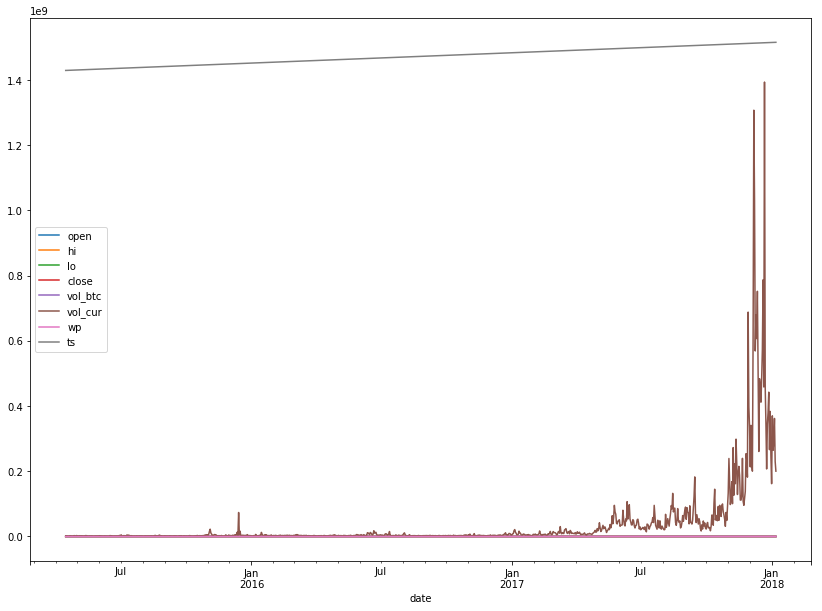

In [6]:
bit_df.plot(figsize=(14,10))

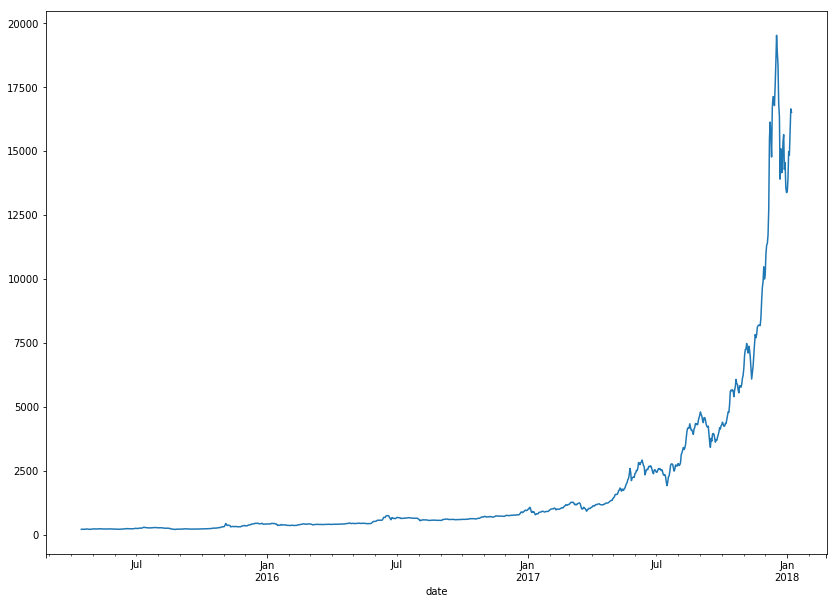

In [7]:
bit_df.close.plot(figsize=(14,10))

## Exercise: Load data
This exercise looks at predicting the size of forest fires based on meteorological data https://archive.ics.uci.edu/ml/datasets/Forest+Fires

The file is in ``../data/forestfires.csv``

* Read the data into a DataFrame
* Examine the types
* Describe the data

Attribute information:

   For more information, read [Cortez and Morais, 2007].

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform).

In [8]:
ff = pd.read_csv('../data/forestfires.csv')

In [9]:
ff.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [10]:
ff.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


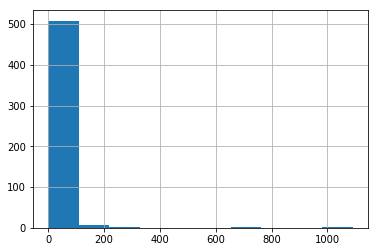

In [11]:
ff.area.hist()

## Can we predict tomorrow's close based on today's info?
We will use a row of data for input. We will call the input X and the prediction y. This is called "supervised learning" as we will feed in both X and y to train the model.

Let's use a model called Linear Regression. This performs better if we *standardize* the data (0 mean, 1 std).

For 2 dimensions this takes the form of 

\begin{align}
y = m*x + b
\end{align}

M is the slope (or coefficient) and b is the intercept.

Let's see if we can predict the open price from the ts component.

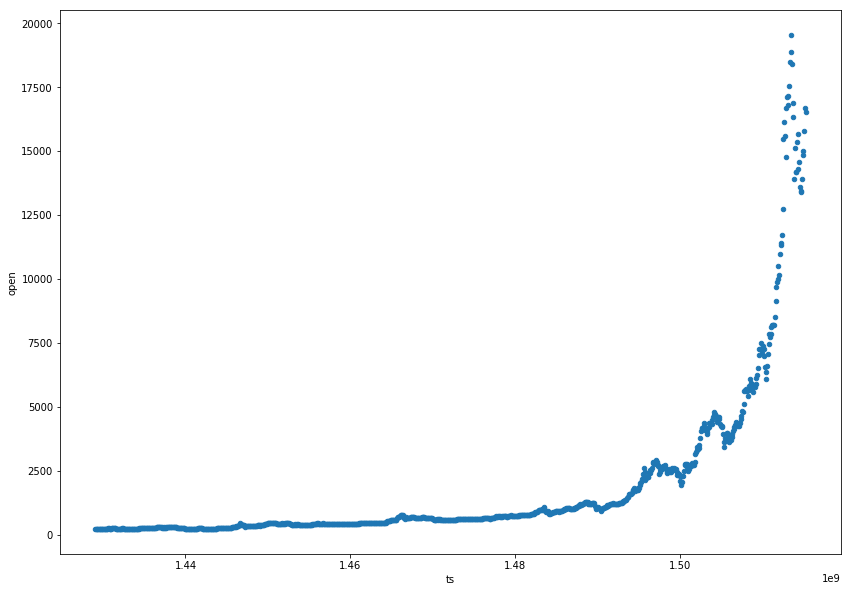

In [12]:
bit_df.plot(kind='scatter', x='ts', y='open', figsize=(14,10))

In [45]:
# Create our input (X) and our labelled data (y) to train our model
X = bit_df[['ts']].iloc[:-1]  # drop last row because we don't know what future is
y = bit_df.close.shift(-1).iloc[:-1]

In [14]:
# Train a model and predict output if it were given X
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)
pred = lr_model.predict(X)

/Users/matt/.env/36/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


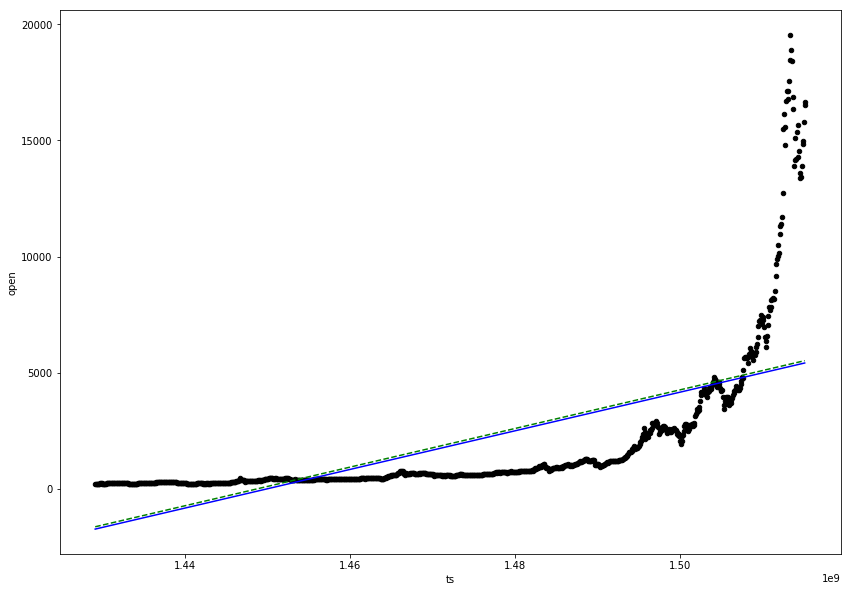

In [15]:
# Plot the real data, our prediction (blue), and the model from the coeffictient (green shifted)
ax = bit_df.plot(kind='scatter', x='ts', y='open', color='black', figsize=(14,10))
ax.plot(X, pred, color='blue')  # matplotlib plot
ax.plot(X, X*lr_model.coef_ + lr_model.intercept_+ 100, linestyle='--', color='green')

In [16]:
# Vertical distance between line and point is the error. *Ordinary Least Squares* 
# regression tries to minimize the square of the distance.
mean_squared_error(y, pred)

5753065.88452148

In [17]:
# R2 score is a measure from 0-100
# 0 - the model explains none of the variation
# 100 - 100% of the variation is explained by the model
print(r2_score(y, pred))
# Not that the .score method gives the same value
print(lr_model.score(X, y))

0.4258082259018654
0.4258082259018654


## Exercise: Regression

* Use linear regression to predict ``area`` from the other columns. (If you have ``object`` data columns, you can create *dummy columns* using ``pd.get_dummies``, ``pd.concat``, and ``pd.drop``)
* What is your score?

In [18]:
ff.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [19]:
yff = ff.area
ff2 = (
    pd.concat([ff, pd.get_dummies(ff.month),
              pd.get_dummies(ff.day)], axis=1)
    .drop(['month', 'day', 'area'], axis=1)
)
Xff = ff2

In [20]:
ff_lr = linear_model.LinearRegression()
ff_lr.fit(Xff, yff)
ff_lr.score(Xff, yff)

0.04578209650808518

In [21]:
np.log(ff.area)

/Users/matt/.env/36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


0          -inf
1          -inf
2          -inf
3          -inf
4          -inf
5          -inf
6          -inf
7          -inf
8          -inf
9          -inf
10         -inf
11         -inf
12         -inf
13         -inf
14         -inf
15         -inf
16         -inf
17         -inf
18         -inf
19         -inf
20         -inf
21         -inf
22         -inf
23         -inf
24         -inf
25         -inf
26         -inf
27         -inf
28         -inf
29         -inf
         ...   
487    2.797281
488    3.843744
489        -inf
490        -inf
491        -inf
492        -inf
493    3.768614
494    2.150599
495        -inf
496    1.018847
497    2.686486
498    3.702289
499    2.381396
500        -inf
501        -inf
502        -inf
503    0.667829
504    3.903789
505    1.757858
506        -inf
507        -inf
508        -inf
509    0.774727
510   -0.843970
511        -inf
512    1.862529
513    3.994340
514    2.412336
515        -inf
516        -inf
Name: area, Length: 517,

In [22]:
np.log(ff.area+1)

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11     0.000000
12     0.000000
13     0.000000
14     0.000000
15     0.000000
16     0.000000
17     0.000000
18     0.000000
19     0.000000
20     0.000000
21     0.000000
22     0.000000
23     0.000000
24     0.000000
25     0.000000
26     0.000000
27     0.000000
28     0.000000
29     0.000000
         ...   
487    2.856470
488    3.864931
489    0.000000
490    0.000000
491    0.000000
492    0.000000
493    3.791436
494    2.260721
495    0.000000
496    1.327075
497    2.752386
498    3.726657
499    2.469793
500    0.000000
501    0.000000
502    0.000000
503    1.081805
504    3.923754
505    1.916923
506    0.000000
507    0.000000
508    0.000000
509    1.153732
510    0.357674
511    0.000000
512    2.006871
513    4.012592
514    2.498152
515    0.000000
516    0.000000
Name: area, Length: 517,

In [23]:
# try log area import numpy as np
def log(x):
    return np.log(x+1)
ff_lr2 = linear_model.LinearRegression()
ff_lr2.fit(Xff, log(yff))
ff_lr2.score(Xff, log(yff))

0.07425967860549865

### Bonus - Visualize the errors
You can plot the actuals and the predicted values. It looks like our model does a pretty poor job

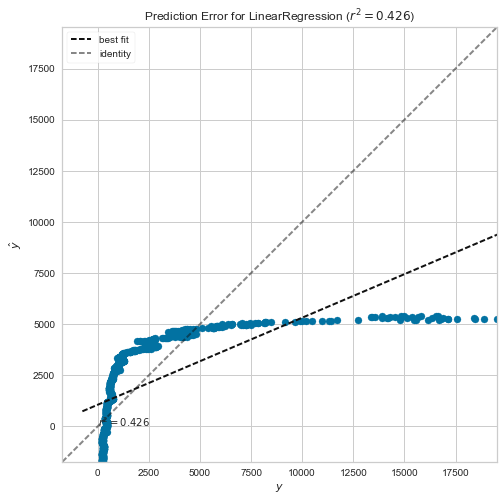

In [48]:
# Prediction error plot from Yellowbrick
# plot of actual (blue) vs predicted (black dash)
# ideally would be around 45 degree line
fig, ax = plt.subplots(figsize=(10, 8))
err_viz = PredictionError(lr_model)
# Model is already fit
#err_viz.fit(X, y)
err_viz.score(X, y)
err_viz.poof()

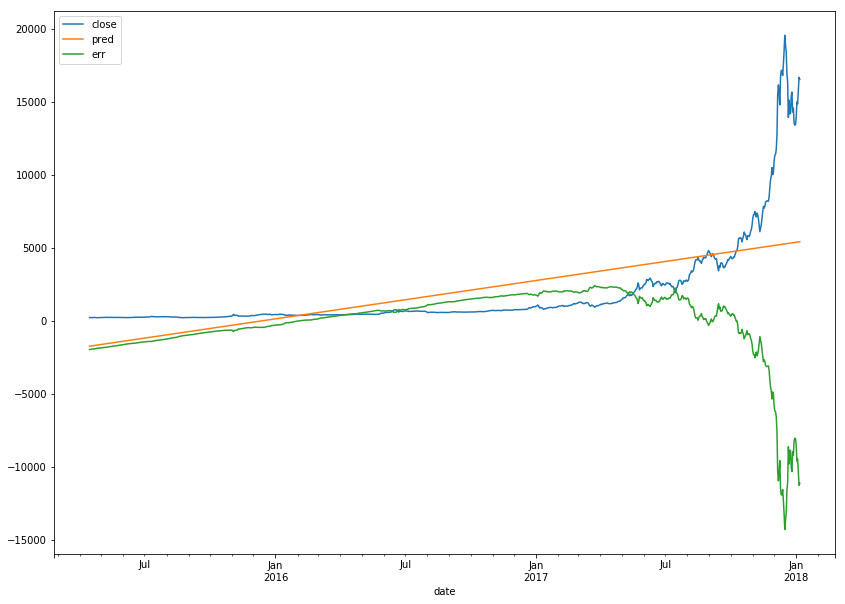

In [24]:
# plot result
y_df = pd.DataFrame(y)
y_df['pred'] = pred
y_df['err'] = y_df.pred - y_df.close
(y_df
 #.iloc[-50:]
 .plot(figsize=(14,10))
)

## Bonus Exercise: Visualize the errors
Plot y and predicted y

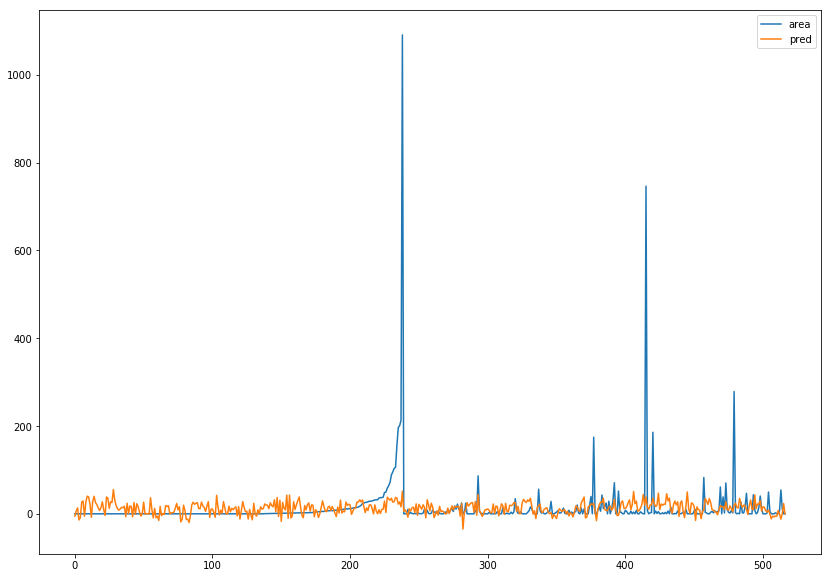

In [25]:
vis_df = pd.DataFrame(ff.area)
vis_df['pred'] = ff_lr.predict(Xff)
vis_df.plot(figsize=(14,10))

## Try More Features
In an attempt to get a better model we are going to use more features to make a prediction

In [26]:
# drop last row because we don't know what future is

X = (bit_df
         .drop(['close'], axis=1)
         .iloc[:-1])
y = bit_df.close.shift(-1).iloc[:-1]
cols = X.columns

In [27]:
# The describe method on a dataframe gives a statistical summary of the columns
X.describe()

,open,hi,lo,vol_btc,vol_cur,wp,ts
count,998.000000,998.000000,998.000000,998.000000,9.980000e+02,998.000000,9.980000e+02
mean,1827.558580,1828.523114,1826.497278,10348.164860,3.537227e+07,1827.510400,1.472126e+09
std,3132.917406,3135.440482,3130.251340,9952.419039,1.096674e+08,3132.853391,2.490412e+07
min,215.946340,216.147903,215.791215,1525.187302,7.925465e+05,215.969046,1.429056e+09
25%,384.192955,384.274087,384.094281,5318.074102,2.297677e+06,384.182499,1.450591e+09
50%,632.345812,632.431142,632.255160,7365.384844,3.480134e+06,632.345289,1.472126e+09
75%,1452.112307,1452.583847,1451.516651,11885.163969,1.957041e+07,1452.074386,1.493662e+09
max,19537.944771,19545.537632,19529.171910,165763.024424,1.393385e+09,19537.276941,1.515197e+09


In [28]:
# We are going to scale the data so that volume and ts don't get more
# weight that other values
ss = preprocessing.StandardScaler()
ss.fit(X)
X = ss.transform(X)
X = pd.DataFrame(X, columns=cols)

In [29]:
# We can now see that the data has a mean close to 0
# and a std of 1
X.describe()

,open,hi,lo,vol_btc,vol_cur,wp,ts
count,9.980000e+02,9.980000e+02,9.980000e+02,9.980000e+02,998.000000,9.980000e+02,9.980000e+02
mean,1.139147e-16,5.695733e-17,5.695733e-17,9.967533e-17,0.000000,-5.695733e-17,-5.695733e-17
std,1.000501e+00,1.000501e+00,1.000501e+00,1.000501e+00,1.000501,1.000501e+00,1.000501e+00
min,-5.146705e-01,-5.144998e-01,-5.148192e-01,-8.869604e-01,-0.315473,-5.146584e-01,-1.730316e+00
25%,-4.609407e-01,-4.608517e-01,-4.610257e-01,-5.056673e-01,-0.301741,-4.609381e-01,-8.651581e-01
50%,-3.816928e-01,-3.816662e-01,-3.817077e-01,-2.998543e-01,-0.290954,-3.816854e-01,0.000000e+00
75%,-1.198993e-01,-1.199601e-01,-1.198526e-01,1.545122e-01,-0.144161,-1.198984e-01,8.651581e-01
max,5.655836e+00,5.653399e+00,5.658188e+00,1.562362e+01,12.389219,5.655753e+00,1.730316e+00


In [30]:
lr_model2 = linear_model.LinearRegression()
lr_model2.fit(X, y)
pred = lr_model2.predict(X)
lr_model2.score(X, y)

0.9963830244144037

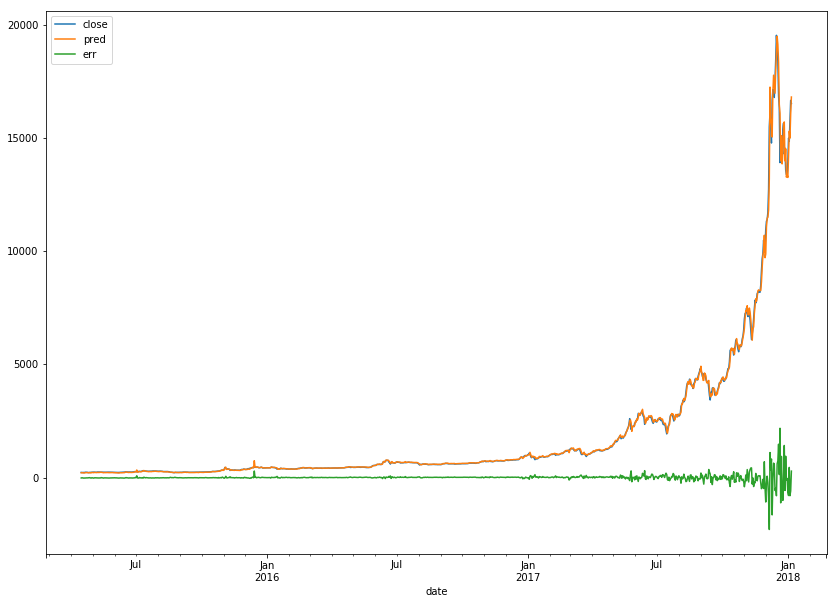

In [31]:
# plot result
y_df = pd.DataFrame(y)
y_df['pred'] = pred
y_df['err'] = y_df.pred - y_df.close
y_df.plot(figsize=(14,10))

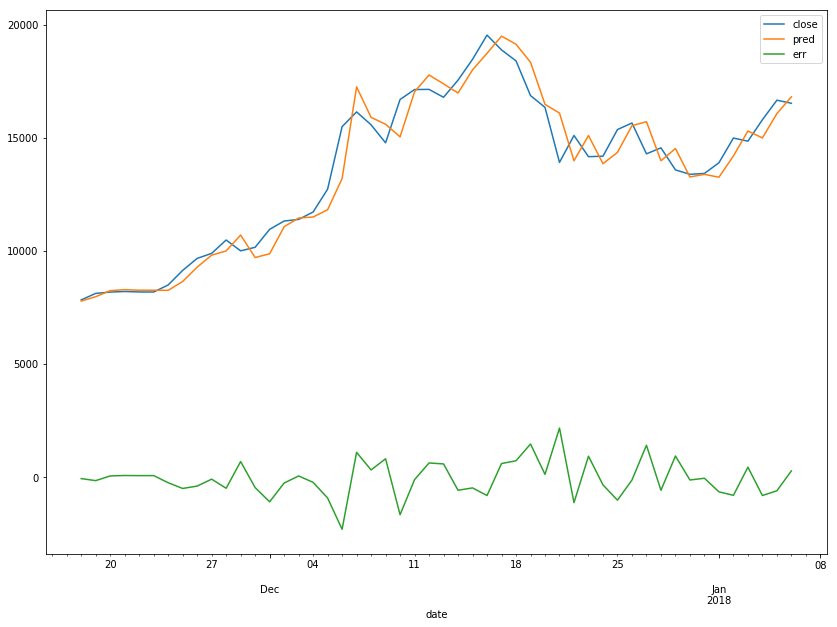

In [32]:
# plot result
y_df = pd.DataFrame(y)
y_df['pred'] = pred
y_df['err'] = y_df.pred - y_df.close
y_df.iloc[-50:].plot(figsize=(14,10))

In [33]:
# our scores get worse with recent data
lr_model2.score(X[-50:], y[-50:])

0.9418835493880745

In [34]:
lr_model2.coef_

array([-1.07719045e+06, -5.25326577e+05, -5.29811675e+05,  1.75700312e+01,
       -2.79825558e+00,  2.13546668e+06,  2.06039328e+01])

In [35]:
list(zip(X.columns, lr_model2.coef_))

[('open', -1077190.449058441),
 ('hi', -525326.5772886947),
 ('lo', -529811.6747175623),
 ('vol_btc', 17.57003118887675),
 ('vol_cur', -2.7982555792060944),
 ('wp', 2135466.6762042),
 ('ts', 20.603932849814736)]

In [36]:
# These coefficients correspond to the columns in X
pd.DataFrame(list(zip(X.columns, lr_model2.coef_)), columns=['Feature', 'Coeff'])

,Feature,Coeff
0,open,-1.077190e+06
1,hi,-5.253266e+05
2,lo,-5.298117e+05
3,vol_btc,1.757003e+01
4,vol_cur,-2.798256e+00
5,wp,2.135467e+06
6,ts,2.060393e+01


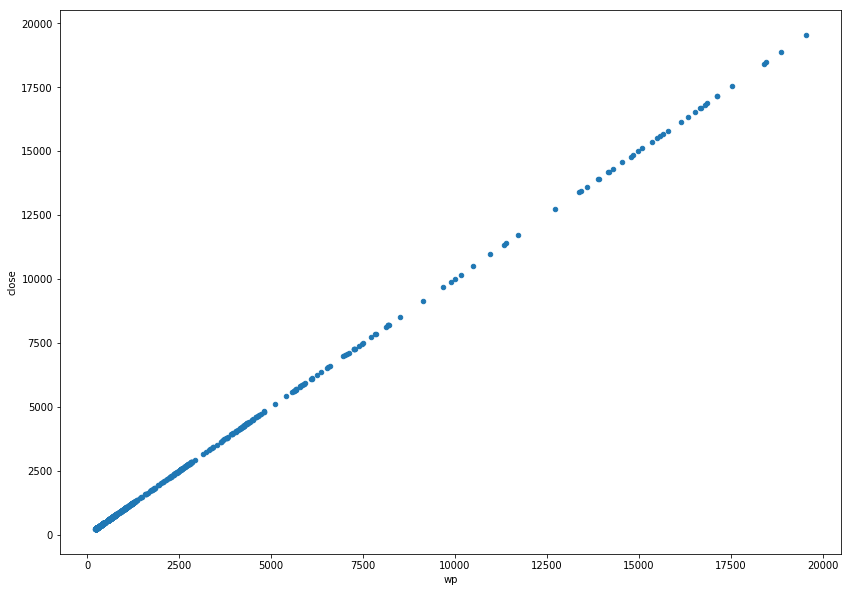

In [37]:
bit_df.plot(kind='scatter', x='wp', y='close', figsize=(14,10))

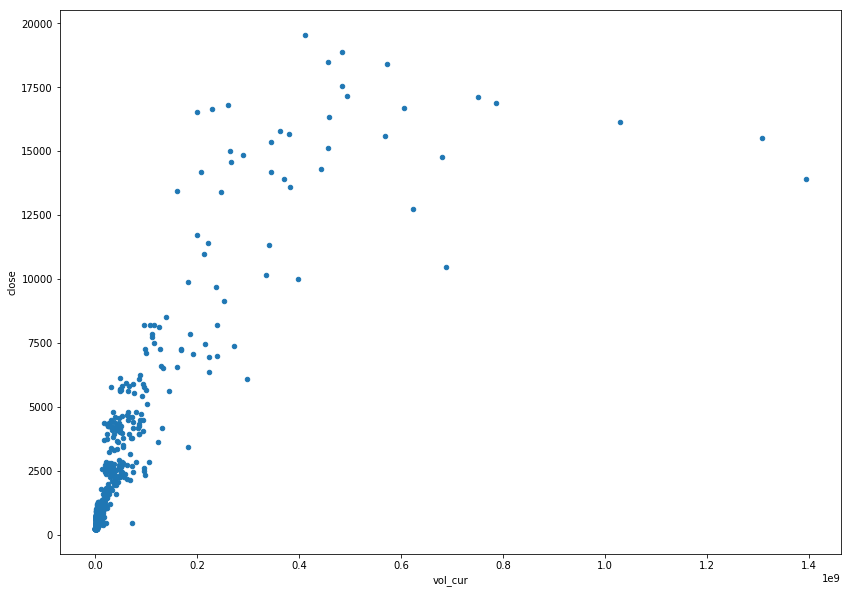

In [38]:
bit_df.plot(kind='scatter', x='vol_cur', y='close', figsize=(14,10))

## Exercise: Regression
* Try scaling the input and using the log of the area and see if you get a better score.

* Examine the coefficients



In [49]:
ss_ff = preprocessing.StandardScaler()
ss_ff.fit(Xff)
X_ff_scaled = ss_ff.transform(Xff)
X_ff_scaled = pd.DataFrame(X_ff_scaled, columns=Xff.columns)
y_ff_scaled = log(ff.area)


In [50]:
ff_lr_scaled = linear_model.LinearRegression()
ff_lr_scaled.fit(X_ff_scaled, y_ff_scaled)
ff_lr_scaled.score(X_ff_scaled, y_ff_scaled)

0.07405647493734202

In [51]:
pd.DataFrame(list(zip(X_ff_scaled.columns, ff_lr_scaled.coef_)),
             columns=['Feature', 'Coeff'])

,Feature,Coeff
0,X,1.166098e-01
1,Y,-2.313022e-02
2,FFMC,3.267286e-02
3,DMC,2.803778e-01
4,DC,-5.151456e-01
5,ISI,-6.676163e-02
6,temp,2.097820e-01
7,RH,1.630830e-02
8,wind,1.080255e-01
9,rain,6.331925e-03


## Training/Test Split
In fact we were cheating, predicting things that we already saw serves little purpose. The model could just memorize the data and get a perfect score. But it wouldn't *generalize* to unseen data.

To see how it will perform in the real world we will train on a portion of the data and test on a portion that it hasn't seen. 

In [86]:
X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size=.3, random_state=42)

In [72]:
lr_model2 = linear_model.LinearRegression()
lr_model2.fit(X_train, y_train)
lr_model2.score(X_test, y_test)

0.9968849364779856

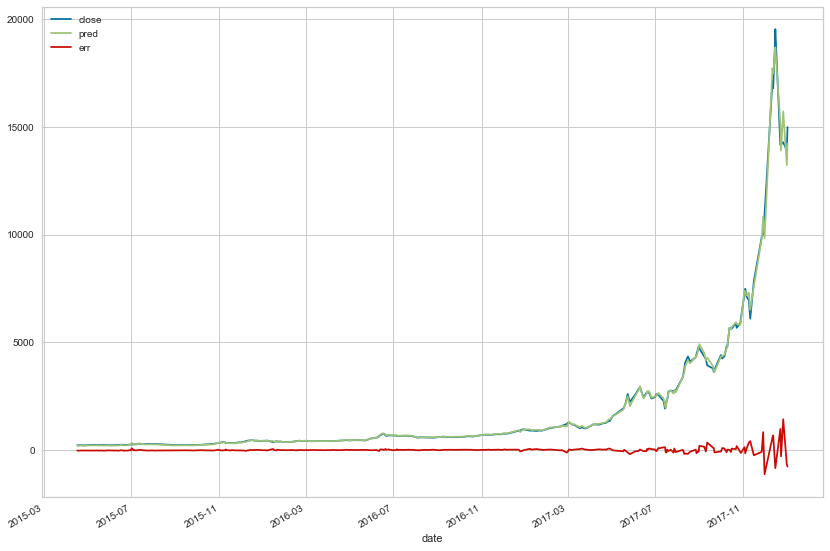

In [73]:
y_df2 = pd.DataFrame(y_test)
y_df2['pred'] = lr_model2.predict(X_test)
y_df2['err'] = y_df2.pred - y_df2.close
(
y_df2
 #   .iloc[-50:]
    .plot(figsize=(14,10))
)

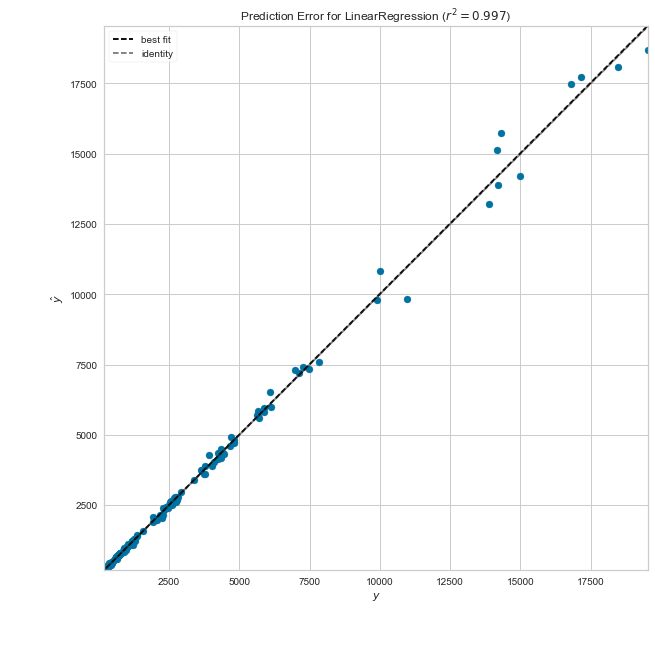

In [76]:
# yellow brick version
fig, ax = plt.subplots(figsize=(10, 10))
err_viz2 = PredictionError(lr_model2)
err_viz2.score(X_test, y_test)
err_viz2.poof()

## Exercise: Regression with Train/Test Split

Split the data into test and training data. What is the score on the test data?

In [55]:
X_ff_train, X_ff_test, y_ff_train, y_ff_test = model_selection.\
    train_test_split(X_ff_scaled, y_ff_scaled, test_size=.3,
                     random_state=42)

In [56]:
ff_lr_scaled2 = linear_model.LinearRegression()
ff_lr_scaled2.fit(X_ff_train, y_ff_train)
ff_lr_scaled2.score(X_ff_test, y_ff_test)

-0.059747941470150064

## Visualize Errors with Residual Plots
A residual is the difference between the prediction and the actual.
If we plot predicted value against residuals, we should get a random
distribution. If not, a different model more be better given the data.

In [81]:
def residual_plot(model, X_train, y_train, X_test, y_test):
    fig = plt.figure(figsize=(14,10))
    ax = plt.subplot(111)
    plt.scatter(model.predict(X_train), 
                model.predict(X_train) - y_train, 
                c='b', alpha=.3,
                label='train')
    plt.scatter(model.predict(X_test), 
                model.predict(X_test) - y_test, 
                color='green', alpha=.3,
                label='test')
    plt.title('Residual Plot - Train (blue), Test (green)')
    plt.ylabel('Residual')
    ax.legend()
    


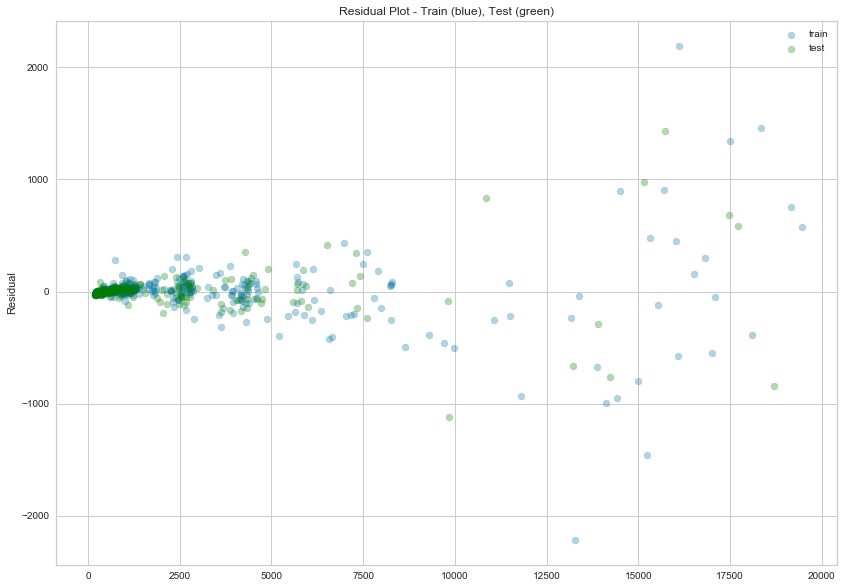

In [87]:
residual_plot(lr_model2, X_train, y_train, X_test, y_test)

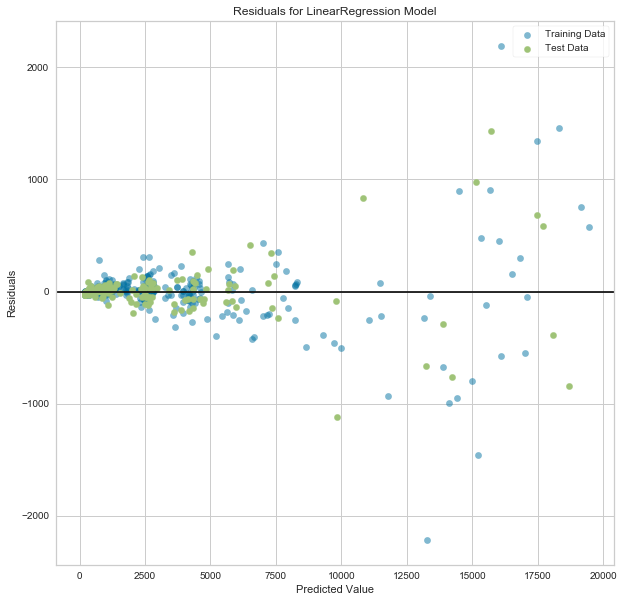

In [88]:
# Yellowbrick version
fig, ax = plt.subplots(figsize=(10, 10))
res_viz = ResidualsPlot(lr_model2)
res_viz.fit(X_train, y_train)
res_viz.score(X_test, y_test)
res_viz.poof()

## Exercise - Residual Plot
Make a residual plot of your test and train data

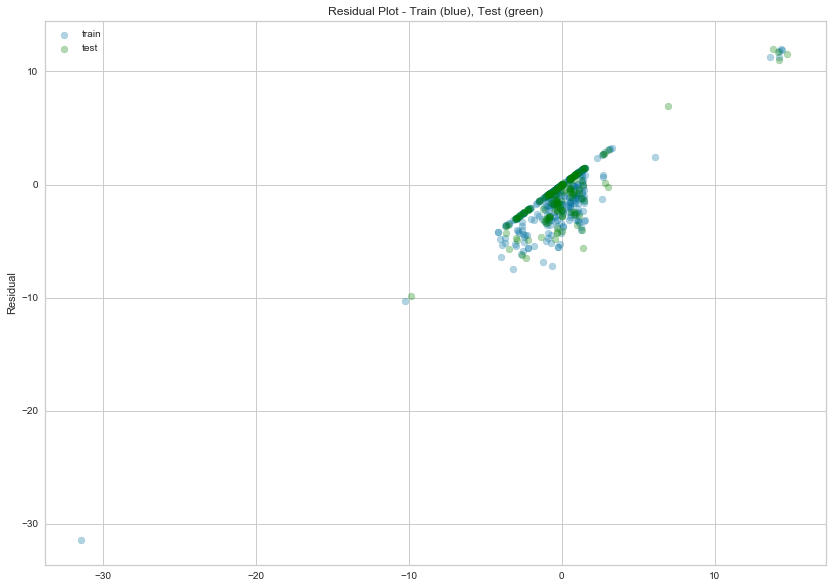

In [84]:


    
residual_plot(ff_lr2, X_ff_train, y_ff_train, X_ff_test, y_ff_test)

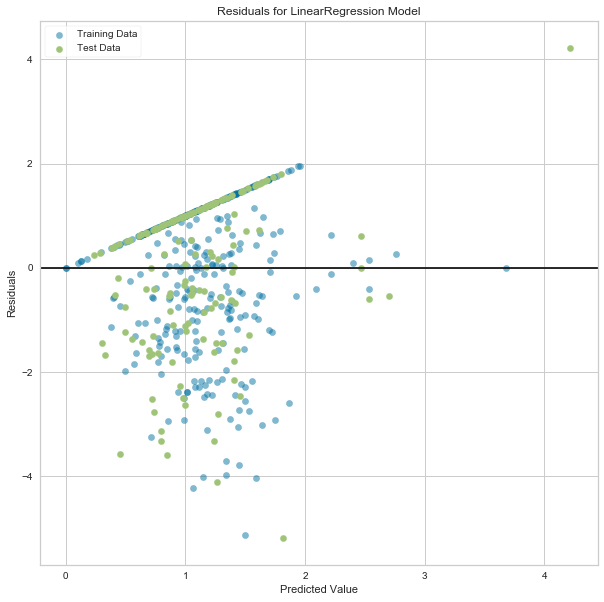

In [85]:
# Yellowbrick version
fig, ax = plt.subplots(figsize=(10, 10))
res_viz2 = ResidualsPlot(ff_lr2)
res_viz2.fit(X_ff_train, y_ff_train)
res_viz2.score(X_ff_test, y_ff_test)
res_viz2.poof()

## SVM, Random Forest, & Huber  - Other models

In [59]:
# drop last row because we don't know what future is

X = (bit_df
         .drop(['close'], axis=1)
         .iloc[:-1])
y = bit_df.close.shift(-1).iloc[:-1]
cols = X.columns

ss = preprocessing.StandardScaler()
ss.fit(X)
X = ss.transform(X)
X = pd.DataFrame(X, columns=cols)

X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size=.3, random_state=42)
    
svm_model = svm.SVR(kernel='linear')
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)    

0.705985163599419

In [60]:
def train_reg_model(model, df):
    # drop last row because we don't know what future is

    X = (df
             .drop(['close'], axis=1)
             .iloc[:-1])
    y = df.close.shift(-1).iloc[:-1]
    cols = X.columns

    ss = preprocessing.StandardScaler()
    ss.fit(X)
    X = ss.transform(X)
    X = pd.DataFrame(X, columns=cols)

    X_train, X_test, y_train, y_test = model_selection.\
        train_test_split(X, y, test_size=.3, random_state=42)

    #svm_model = svm.SVR(kernel='linear')
    model.fit(X_train, y_train)
    return model.score(X_test, y_test), X_test, y_test, X_train, y_train    
    
rf_reg = ensemble.RandomForestRegressor() 
score, X_test, y_test, X_train, y_train = train_reg_model(rf_reg, bit_df)
print(score)    

0.994598406316293


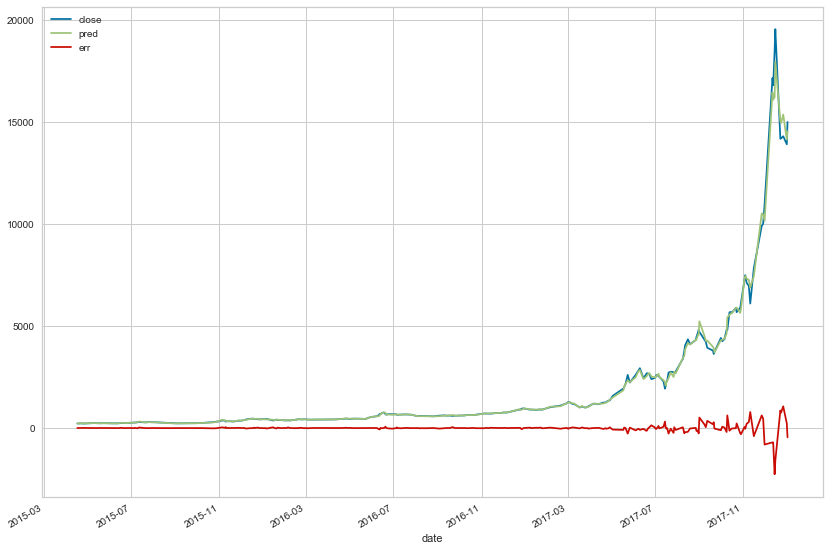

In [61]:
def error_plot(X_test, y_test, model):
    y_df3 = pd.DataFrame(y_test)
    y_df3['pred'] = model.predict(X_test)
    y_df3['err'] = y_df3.pred - y_df3.close
    (
    y_df3
     #   .iloc[-50:]
        .plot(figsize=(14,10))
    )
error_plot(X_test, y_test, rf_reg)

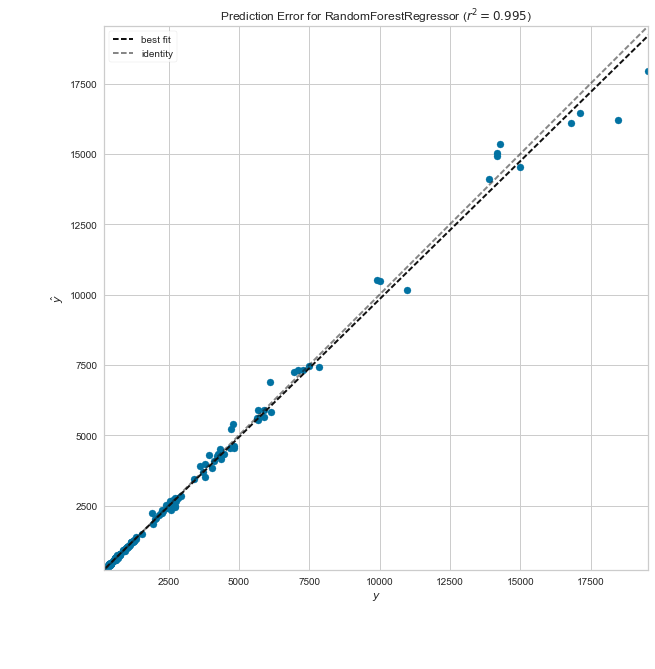

In [89]:
# yellow brick version
fig, ax = plt.subplots(figsize=(10, 10))
err_viz3 = PredictionError(rf_reg)
err_viz3.score(X_test, y_test)
err_viz3.poof()

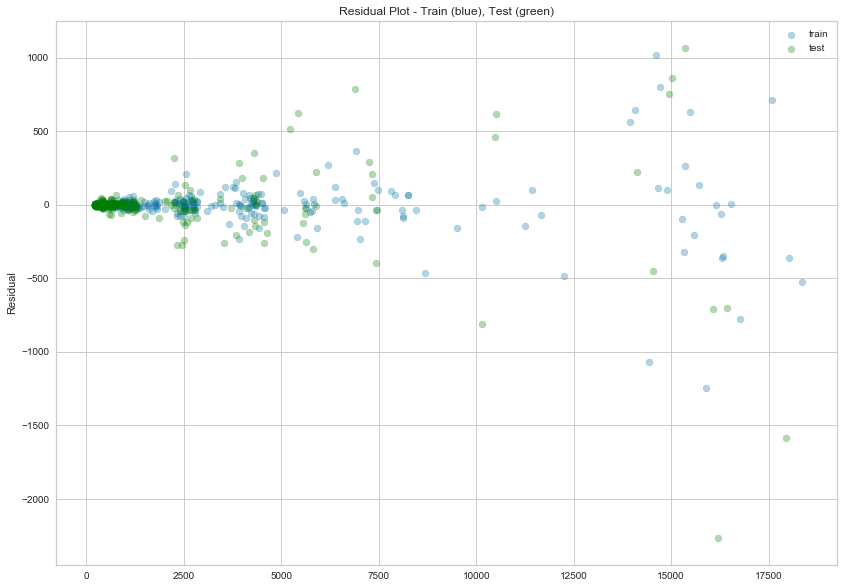

In [62]:

    
residual_plot(rf_reg, X_train, y_train, X_test, y_test)

In [63]:
huber_reg = linear_model.HuberRegressor()
huber_reg.fit(X_train, y_train)
huber_reg.score(X_test, y_test)

/Users/matt/.env/36/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


0.9968686980198107

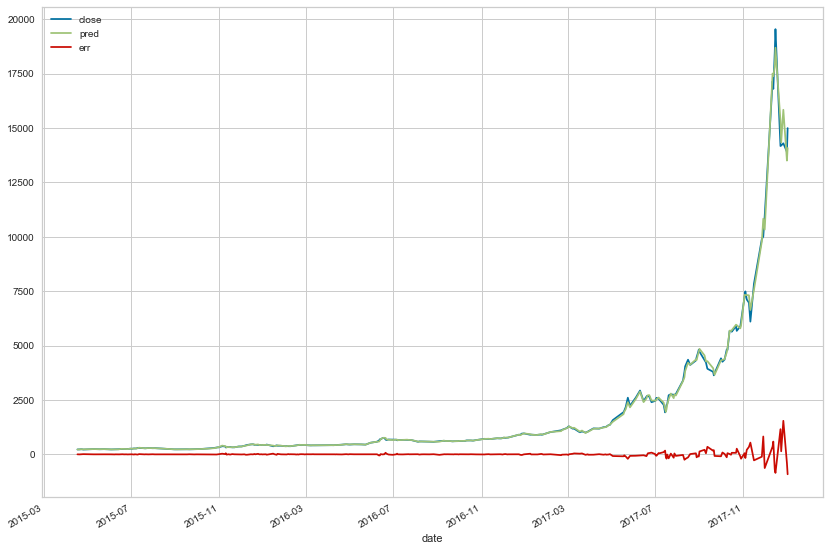

In [64]:
error_plot(X_test, y_test, huber_reg)

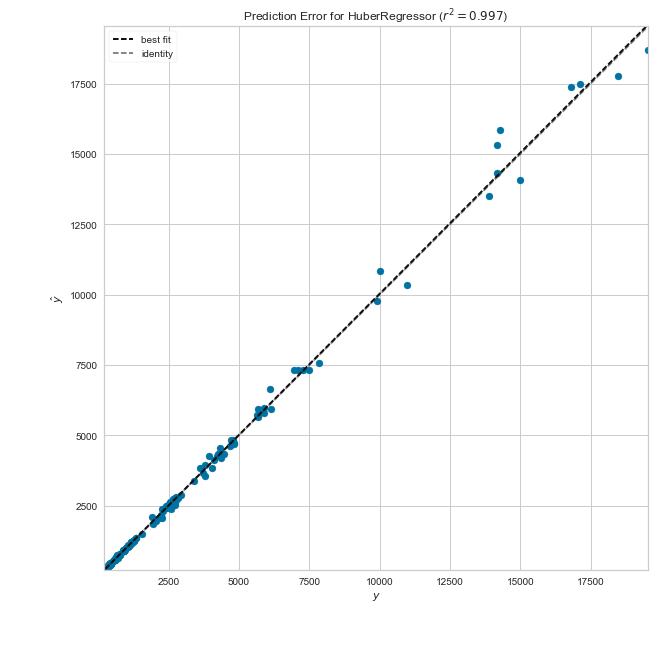

In [90]:
# yellow brick version
fig, ax = plt.subplots(figsize=(10, 10))
err_viz4 = PredictionError(huber_reg)
err_viz4.score(X_test, y_test)
err_viz4.poof()

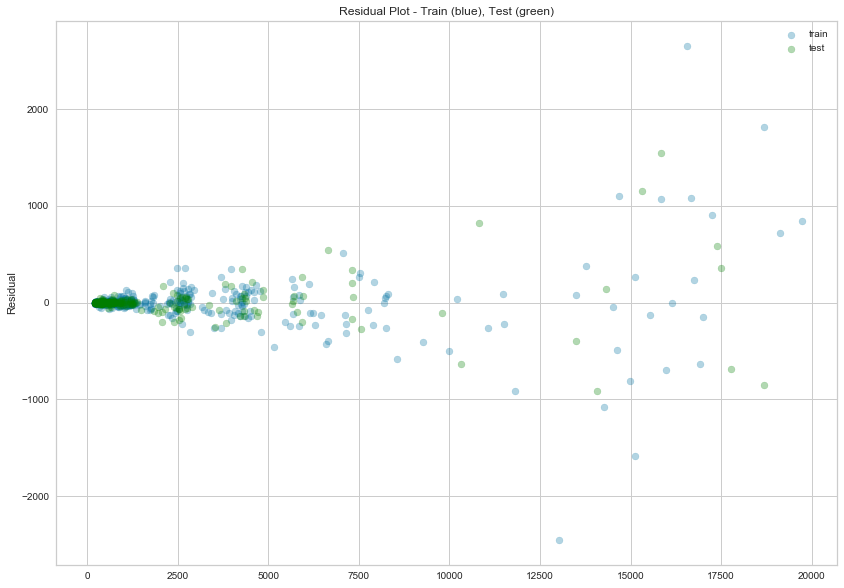

In [65]:
residual_plot(huber_reg, X_train, y_train, X_test, y_test)

In [66]:
huber_reg

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

## Exercise:

Try using another model (RandomForestRegressor or SVM)

In [67]:
rf_ff = ensemble.RandomForestRegressor()
rf_ff.fit(X_ff_train, y_ff_train)
rf_ff.score(X_ff_test, y_ff_test)

-0.0738125613542071

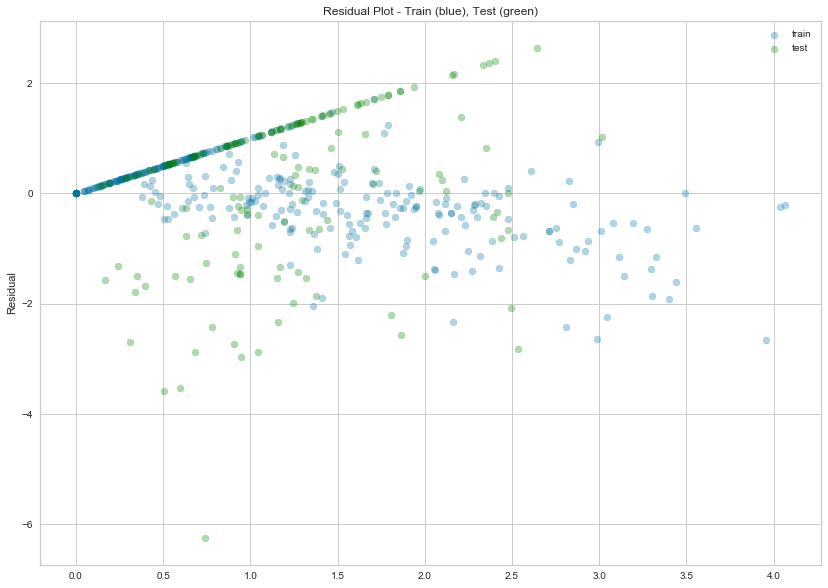

In [68]:
residual_plot(rf_ff, X_ff_train, y_ff_train, X_ff_test, y_ff_test)

In [69]:
svm_ff = svm.SVR()
svm_ff.fit(X_ff_train, y_ff_train)
svm_ff.score(X_ff_test, y_ff_test)

-0.17761583400326386